https://breezymind.com/kcbert-find-tuning/

In [3]:
!pip install transformers

In [76]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from transformers import ElectraModel, ElectraTokenizer
from transformers import AutoTokenizer, ElectraForSequenceClassification
from sklearn.metrics import f1_score, confusion_matrix

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}

In [78]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Wed Oct  4 16:35:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA 

# load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks
%pwd

In [150]:
rawdata.head()

,label,speech
0,일반적인 말,오늘 우리 마당에 귀여운 토끼가 있었어
1,부정적인 말,날 귀찮게 하고있어
2,반영,포테이토 헤드를 위한 모자이구나
3,지시,그림에 말을 그리렴
4,행동 묘사,우리는 색칠을 하고 있어


In [79]:
rawdata = pd.read_csv('./preprocess_PCIT_labeled_09272023.csv')
rawdata.head()

,label,speech
0,일반적인 말,오늘 우리 마당에 귀여운 토끼가 있었어
1,부정적인 말,날 귀찮게 하고있어
2,반영,포테이토 헤드를 위한 모자이구나
3,지시,그림에 말을 그리렴
4,행동 묘사,우리는 색칠을 하고 있어


In [80]:
len(rawdata)

5748

In [81]:
# rawdata.drop(['Unnamed: 0'], axis=1, inplace=True)
# rawdata

In [82]:
rawdata['label'].value_counts()

일반적인 말     1136
지시          910
행동 묘사       755
질문          716
반영          704
구체적인 칭찬     684
부정적인 말      619
일반적인 칭찬     224
Name: label, dtype: int64

In [83]:
labels = rawdata.label.unique()
labels

array(['일반적인 말', '부정적인 말', '반영', '지시', '행동 묘사', '일반적인 칭찬', '질문',
       '구체적인 칭찬'], dtype=object)

In [84]:
labels = ['일반적인 말', '부정적인 말', '반영', '지시', '행동 묘사', '질문', '일반적인 칭찬', '구체적인 칭찬']

In [85]:
label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
label_dict

{'일반적인 말': 0,
 '부정적인 말': 1,
 '반영': 2,
 '지시': 3,
 '행동 묘사': 4,
 '질문': 5,
 '일반적인 칭찬': 6,
 '구체적인 칭찬': 7}

In [86]:
len(label_dict)

8

In [87]:
rawdata['label_ct'] = rawdata.label.replace(label_dict)

In [88]:
rawdata.tail(5)

,label,speech,label_ct
5743,반영,인형을 제시카라고 부르는구나,2
5744,구체적인 칭찬,멋진 공룡을 그렸구나,7
5745,반영,내거야 내가 원하면 꽉 누를 수 있어,2
5746,질문,그것은 무엇이니,5
5747,구체적인 칭찬,노력하고 있구나 잘했어,7


In [89]:
rawdata["Words Per Sentence"] = rawdata["speech"].str.split().apply(len)

In [90]:
len(rawdata)

5748

# analyse data

In [91]:
# 한글 출력

from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib as plt

!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

# fm._rebuild()
# fm.get_fontconfig_fonts()

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = './NanumGothic.ttf'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [92]:
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정


In [98]:
distrubution_data = rawdata.groupby(by='label_ct')[['label_ct']].count()
# distrubution_data.columns=['label', 'frequency']
distrubution_data

,label_ct
label_ct,
0,1136
1,619
2,704
3,910
4,755
5,716
6,224
7,684


<Figure size 1000x600 with 0 Axes>

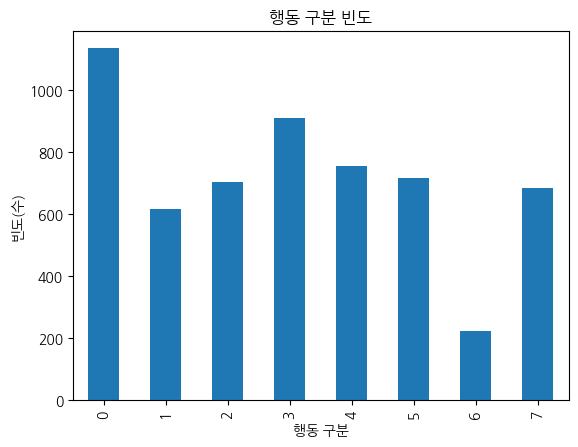

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
distrubution_data.plot(kind='bar'
                      ,title = '행동 구분 빈도'
                      ,xlabel = '행동 구분'
                      ,ylabel = '빈도(수)',
                       legend = None)

plt.savefig(f"{'result_image/distrubution_data_1.png'}",dpi=300)

In [100]:
distrubution_data2 = rawdata.groupby(by='label')[['label']].count()
distrubution_data2 = distrubution_data2.reindex(['일반적인 말', '부정적인 말', '반영', '지시', '행동 묘사', '질문', '일반적인 칭찬', '구체적인 칭찬'])
distrubution_data2

,label
label,
일반적인 말,1136
부정적인 말,619
반영,704
지시,910
행동 묘사,755
질문,716
일반적인 칭찬,224
구체적인 칭찬,684


<Figure size 10000x10000 with 0 Axes>

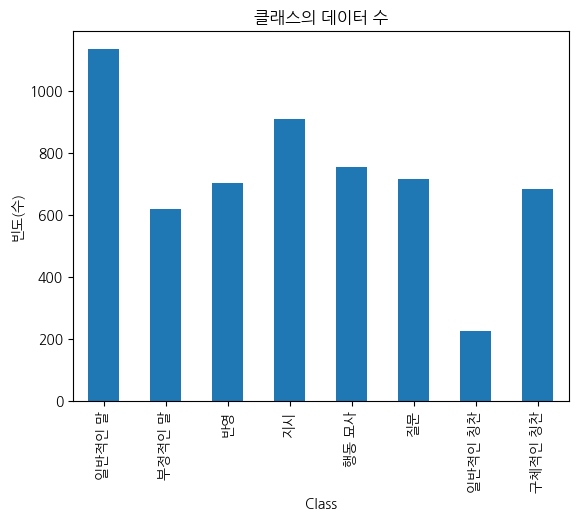

In [105]:
plt.figure(figsize=(100,100))

distrubution_data2.plot(kind='bar'
                      ,title = '클래스의 데이터 수'
                      ,xlabel = 'Class'
                      ,ylabel = '빈도(수)',
                        legend = None)

plt.savefig(f"{'result_image/distrubution_data_2.png'}",dpi=300)

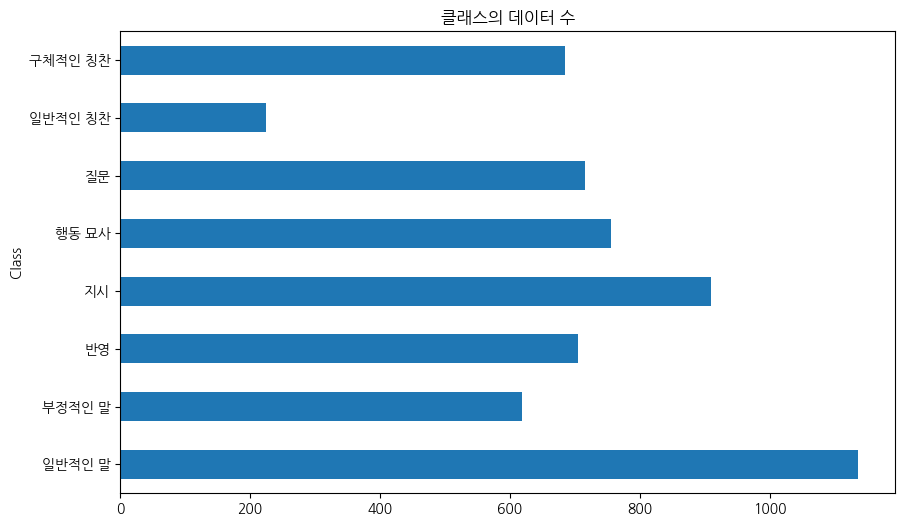

In [104]:
plt.figure(figsize=(10, 6))

distrubution_data2["label"].plot.barh()
plt.title("클래스의 데이터 수")
plt.ylabel("Class")
plt.savefig(f"{'result_image/distrubution_data_3.png'}",dpi=300)
plt.show()

In [106]:
rawdata.head(10)

,label,speech,label_ct,Words Per Sentence
0,일반적인 말,오늘 우리 마당에 귀여운 토끼가 있었어,0,6
1,부정적인 말,날 귀찮게 하고있어,1,3
2,반영,포테이토 헤드를 위한 모자이구나,2,4
3,지시,그림에 말을 그리렴,3,3
4,행동 묘사,우리는 색칠을 하고 있어,4,4
5,부정적인 말,색칠한 그림이 엉망이구나,1,3
6,부정적인 말,테이블 위에 서있는 건 용납되지 않아,1,6
7,반영,집에 가고 싶구나,2,3
8,부정적인 말,아니야,1,1
9,부정적인 말,이곳에서 부스러기를 떨어뜨리며 쿠를 먹지마,1,5


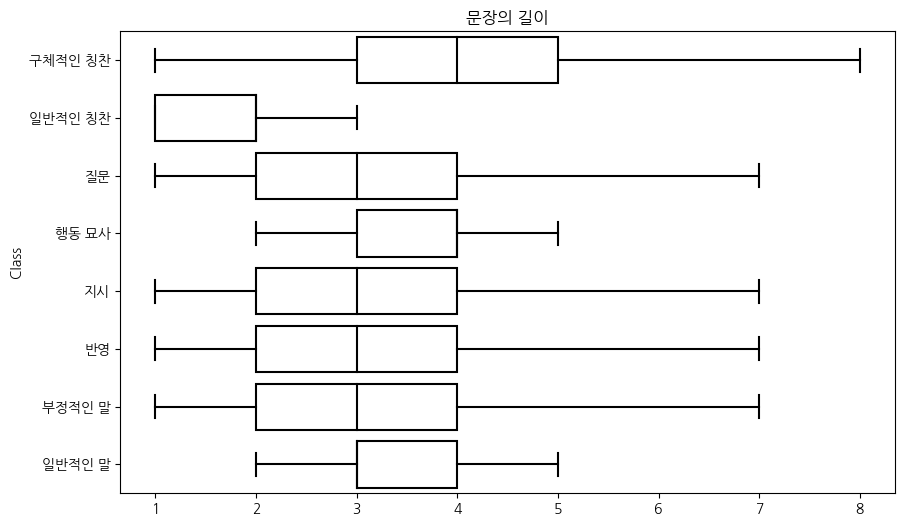

In [107]:
import seaborn as sns
rawdata["Words Per Sentence"] = rawdata["speech"].str.split().apply(len)

plt.figure(figsize=(10, 6))

ax = sns.boxplot(data = rawdata,
                 y = 'label',
                 x = 'Words Per Sentence',
                showfliers=False,
                color="black",
                boxprops={'facecolor':'None'},
                order = ['구체적인 칭찬', '일반적인 칭찬', '질문', '행동 묘사', '지시', '반영', '부정적인 말', '일반적인 말'])

ax.set(xlabel = None, ylabel = 'Class', title = '문장의 길이')

plt.savefig(f"{'result_image/distrubution_data_4.png'}",dpi=300)

# rawdata.boxplot("Words Per Sentence",
#                 by="label",
#                 grid=False,
#                 showfliers=False,
#                 color="black",
#                 vert=False,
#                 )

# plt.suptitle("")
# plt.ylabel("")
# plt.xlabel("")
# plt.show()

In [ ]:
rawdata.head()

# select model
- 3 모델 중에 하나를 선택
- koBERT는 토크나이저 만들 때 다른 모듈 사용

## 1. koBERT

### skt/kobert-base-v1

In [51]:
# # just koBERT
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-1l2qk0rg/kobert-tokenizer_e1e1dcb4c265431fb69aa9a254e480b3
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-1l2qk0rg/kobert-tokenizer_e1e1dcb4c265431fb69aa9a254e480b3
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [52]:
# # KoBERT 모델과 토크나이저 로드
# from transformers import BertTokenizer

In [53]:
# # koBERT
# model_name = "skt/kobert-base-v1"
# from kobert_tokenizer import KoBERTTokenizer
# tokenizer = KoBERTTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### monologg/kobert

In [227]:
model_name = "monologg/kobert"
# model_name = "JuneKo/koBERT_parent_09252023_MLM"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2. kcBERT

In [241]:
# kcBERET
# model_name = "beomi/kcbert-base"
model_name = "JuneKo/kcBERT_parent_09252023_MLM"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

Some weights of the model checkpoint at JuneKo/kcBERT_parent_09252023_MLM were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JuneKo/kcBE

## 3. kcELECTRA

In [258]:
#kcELECTRA
model_name = "beomi/KcELECTRA-base-v2022"
# model_name = "JuneKo/kcELECTRA_parent_09252023_MLM"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'c

# split data

In [52]:
len(tokenizer)

54343

In [53]:
len(labels)

1

In [259]:
texts = []
labels = []

for idx, label in rawdata.iterrows():
  texts.append(label['speech'])
  labels.append(label['label_ct'])

# 원하는 최대 시퀀스 길이
max_length = 16

labels = torch.tensor(labels, dtype=torch.long)
dataset = CustomDataset(texts, labels, tokenizer, max_length)

# 데이터 로더 생성
batch_size = 11

# Train / Test set 분리
from sklearn.model_selection import train_test_split
train, valid = train_test_split(dataset, test_size=0.15, random_state=42)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=True)

## balanced - oversampling

In [21]:
# !pip show scikit-learn
# !pip install --upgrade scikit-learn
# !pip show imbalanced-learn
# !pip install --upgrade imbalanced-learn

In [20]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample
# import torch
# from torch.utils.data import DataLoader

# # 데이터프레임으로 변환
# rawdata = pd.DataFrame({'speech': rawdata['speech'], 'label_ct': rawdata['label_ct']})

# # 원하는 최대 시퀀스 길이
# max_length = 16

# # labels와 texts 추출
# labels = rawdata['label_ct']
# texts = rawdata['speech']

# # Train 및 Validation 데이터로 분할
# X_train, X_valid, y_train, y_valid = train_test_split(texts, labels, test_size=0.15, random_state=42)

# # Train 데이터를 데이터프레임으로 변환
# train_df = pd.DataFrame({'speech': X_train, 'label_ct': y_train})
# valid_df = pd.DataFrame({'speech': X_valid, 'label_ct': y_valid})

# # 소수 클래스와 다수 클래스로 분할
# minority_class = train_df[train_df['label_ct'] == 6]  # 'label_ct'는 클래스 레이블 컬럼 이름으로 바꿔주세요.
# majority_class = train_df[train_df['label_ct'] == 2]

# # 소수 클래스 오버샘플링
# minority_class_oversampled = resample(minority_class,
#                                        replace=True,  # 복원 추출
#                                        n_samples=len(majority_class),  # 다수 클래스와 같은 수로 오버샘플링
#                                        random_state=42)

# # 오버샘플링된 소수 클래스와 다수 클래스 결합
# filtered_train_df = train_df[train_df['label_ct'] != 6]
# oversampled_train_df = pd.concat([filtered_train_df, minority_class_oversampled])

# train_texts = []
# train_labels = []
# valid_texts = []
# valid_labels = []
# for idx, label in oversampled_train_df.iterrows():
#   train_texts.append(label['speech'])
#   train_labels.append(label['label_ct'])

# for idx, label in valid_df.iterrows():
#   valid_texts.append(label['speech'])
#   valid_labels.append(label['label_ct'])

# train_labels = torch.tensor(train_labels, dtype=torch.long)
# train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
# valid_labels = torch.tensor(valid_labels, dtype=torch.long)
# valid_dataset = CustomDataset(valid_texts, labels, tokenizer, max_length)

# # # 'speech' 컬럼은 텍스트 데이터입니다.
# # oversampled_texts = oversampled_train_df['speech'].values
# # valid_texts = valid_df['speech'].values

# # # 'label_ct' 컬럼은 레이블입니다.
# # oversampled_labels = oversampled_train_df['label_ct'].values
# # valid_labels = valid_df['label_ct'].values

# # 토크나이저를 사용하여 텍스트를 토큰으로 변환합니다.
# # encoded_oversampled_texts = tokenizer(oversampled_texts, padding=True, truncation=True, return_tensors='pt')
# # encoded_valid_texts = tokenizer(valid_texts, padding=True, truncation=True, return_tensors='pt')


# # dataset = CustomDataset(texts, labels, tokenizer, max_length)

# # DataLoader 생성
# # train_dataset = TensorDataset(encoded_oversampled_texts['input_ids'], encoded_oversampled_texts['attention_mask'], torch.tensor(oversampled_labels, dtype=torch.long))
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# # valid_dataset = CustomDataset(encoded_oversampled_texts['input_ids'], encoded_oversampled_texts['attention_mask'], torch.tensor(oversampled_labels, dtype=torch.long))
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# # 이제 oversampled_train_dataloader를 사용하여 오버샘플링된 Train 데이터셋으로 학습을 진행합니다.


In [142]:
distrubution_data4 = oversampled_train_df.groupby(by='label_ct')[['label_ct']].count()
# distrubution_data.columns=['label', 'frequency']
distrubution_data4

,label_ct
label_ct,
0,977
1,543
2,568
3,762
4,616
5,646
6,568
7,626


In [125]:
print(train_dataloader)

In [ ]:
# test

In [75]:
len(train), len(valid)

(4885, 863)

In [ ]:
# rawdata['data_type'] = ['not_set']*rawdata.shape[0]

# rawdata.loc[train, 'data_type'] = 'train'
# rawdata.loc[valid, 'data_type'] = 'val'

In [ ]:
# rawdata.groupby(['label', 'label_ct', 'data_type']).count()

In [ ]:
# tokenizer.decode(dataset[0]['input_ids'], skip_special_tokens=True)

# train

In [260]:
print(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = model.to(device)

# 하이퍼파라미터 설정
learning_rate = 1e-5
epochs = 4

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# # weight for imbalanced class
# # 클래스 당 데이터 수
# class_counts = np.array([1136,619,704,910,755,716,224,684])

# # 클래스 빈도의 역수 계산
# class_weights = 1.0 / class_counts

# # 가장 작은 역수 값을 1로 정규화
# class_weights /= min(class_weights)
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# # 손실 함수 초기화
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# metrcis 초기화
training_loss = []
validation_loss = []
Accuracy =[]
F1 =[]

# 모델 재학습
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []

    for batch in train_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()
        # 모델에 입력을 주어 예측을 생성합니다.
        outputs = model(input_ids, attention_mask=attention_mask)
        # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
        logits = outputs.logits
        # 손실을 계산합니다.
        loss = criterion(logits, labels)
        # 역전파를 통해 그래디언트 계산
        loss.backward()
        # 옵티마이저를 사용해 가중치를 업데이트
        optimizer.step()
        # 에포크 전체 손실을 누적합니다.
        total_loss += loss.item()

    # 에포크 평균 손실 계산
    avg_loss = total_loss / len(train_dataloader)
    # 에포크별 손실 출력
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

    # 모델 평가
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_batch in valid_dataloader:
            # Validation 데이터 가져오기
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_labels = val_batch['label']

            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)

            # 모델 예측
            val_outputs = model(val_input_ids, attention_mask=val_attention_mask)
            val_logits = val_outputs.logits

            # 손실 계산
            val_loss = criterion(val_logits, val_labels)
            val_total_loss += val_loss.item()

            # 정확도 계산
            val_preds = val_logits.argmax(dim=1)
            correct += (val_preds == val_labels).sum().item()
            total += val_labels.size(0)
            
            # F1 점수 계산을 위해 모든 예측과 레이블을 저장
            all_val_preds.extend(val_preds.cpu().numpy())
            all_val_labels.extend(val_labels.cpu().numpy())

    val_avg_loss = val_total_loss / len(valid_dataloader)
    val_accuracy = correct / total
    
    # F1 점수 계산
    f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    
    training_loss.append(avg_loss)
    validation_loss.append(val_avg_loss)
    Accuracy.append(val_accuracy)
    F1.append(f1)

    print(f"Validation Loss: {val_avg_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - F1 Score: {f1:.4f}")
    
# https://www.thedatahunt.com/trend-insight/f1-score

beomi/KcELECTRA-base-v2022
True


/home/tools/anaconda/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4 - Avg Loss: 1.5850
Validation Loss: 0.9734 - Validation Accuracy: 0.7173 - F1 Score: 0.7078
Epoch 2/4 - Avg Loss: 0.8337
Validation Loss: 0.7792 - Validation Accuracy: 0.7532 - F1 Score: 0.7501
Epoch 3/4 - Avg Loss: 0.6512
Validation Loss: 0.7500 - Validation Accuracy: 0.7613 - F1 Score: 0.7643
Epoch 4/4 - Avg Loss: 0.5447
Validation Loss: 0.7692 - Validation Accuracy: 0.7671 - F1 Score: 0.7666


In [63]:
class_weights

array([1.        , 1.83521809, 1.61363636, 1.24835165, 1.50463576,
       1.58659218, 5.07142857, 1.66081871])

# result

In [ ]:
# 오차 행렬 계산
cm = confusion_matrix(all_val_labels, all_val_preds)
print("Confusion Matrix:")
print(cm)

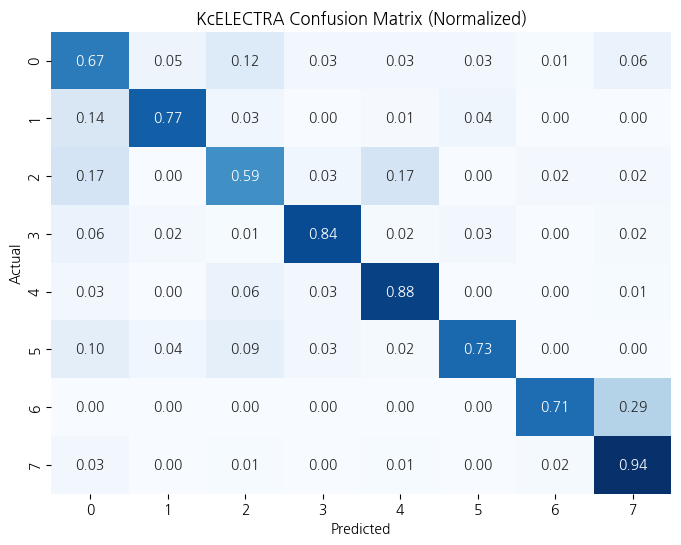

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# 오차 행렬 계산
cm = confusion_matrix(all_val_labels, all_val_preds)

# 각 셀 값을 비율로 변환
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 오차 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KcELECTRA Confusion Matrix (Normalized)')

plt.savefig(f"{'result_image/KcELECTRA_Confusion_Matrix'}.png", dpi=300)
plt.show()



In [72]:
label_dict
reverse_label_dict = dict(map(reversed,label_dict.items()))
reverse_label_dict

{0: '일반적인 말',
 1: '부정적인 말',
 2: '반영',
 3: '지시',
 4: '행동 묘사',
 5: '질문',
 6: '일반적인 칭찬',
 7: '구체적인 칭찬'}

In [ ]:
# import time
# time_stamp = time.strftime('%Y%m%d%H%M', time.localtime(time.time()))
# time_stamp

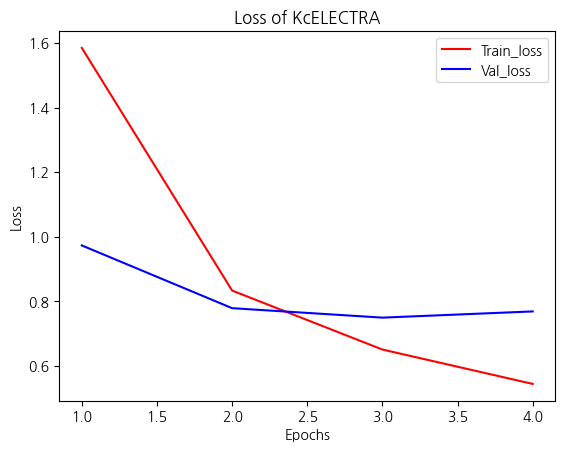

In [262]:
epochs = range(1,5)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, training_loss, 'r', label='Train_loss')
# b는 "파란 실선"입니다
plt.plot(epochs, validation_loss, 'b', label='Val_loss')
plt.title('Loss of KcELECTRA')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f"{'result_image/KcELECTRA_classification_Loss'}.png", dpi=300)

# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.title('Loss of Model with Attention layer')
# plt.legend()
# plt.show()

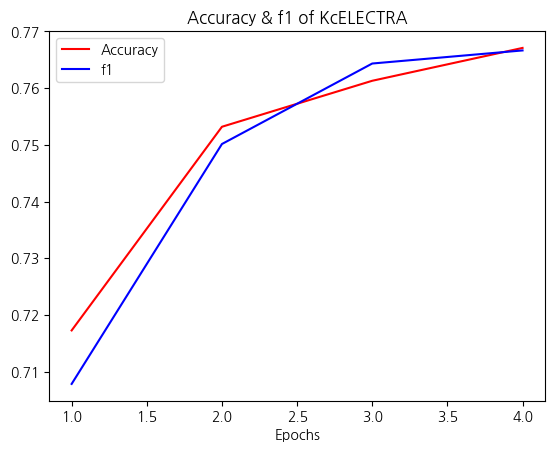

In [263]:
epochs = range(1,5)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, Accuracy, 'r', label='Accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, F1, 'b', label='f1')
plt.title('Accuracy & f1 of KcELECTRA')
plt.xlabel('Epochs')
plt.legend()

plt.savefig(f"{'result_image/KcELECTRA_classification_Accuracy'}.png", dpi=300)

In [ ]:
!pwd

In [264]:
# 모델 저장
model_save_path = "result/KcELECTRA_classification_epoch4_maxlength16.pth"
torch.save(model.state_dict(), model_save_path)

# 모델 아키텍처 생성
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

# 저장된 가중치 불러오기
loaded_model.load_state_dict(torch.load(model_save_path))

# 모델을 평가 모드로 설정
loaded_model.eval()

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'c

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
from google.colab import files
files.download("kc_bert_emotion_classifier.pth")

# t-SNE

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch

In [88]:
# koBERT, kcBERT, kcELECTRA
#kcELECTRA
model_name = "beomi/KcELECTRA-base-v2022"
# model_name = "JuneKo/kcELECTRA_parent_09252023_MLM"

model = AutoModel.from_pretrained(model_name)

# 텍스트 데이터를 BERT 임베딩으로 변환
embeddings = []

# for text in rawdata['speech']:
#     input_ids = tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True)
#     with torch.no_grad():
#         outputs = model(torch.tensor([input_ids]))[0]
#     pooled_output = outputs.mean(dim=1).squeeze().numpy()
#     embeddings.append(pooled_output)
    
labels = []

for text, label in zip(rawdata['speech'], rawdata['label_ct']):
    input_ids = tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True)
    with torch.no_grad():
        outputs = model(torch.tensor([input_ids]))[0]
    pooled_output = outputs.mean(dim=1).squeeze().numpy()
    embeddings.append(pooled_output)
    labels.append(label)

# Python 리스트를 NumPy 배열로 변환
embeddings = np.array(embeddings)

# t-SNE를 사용하여 임베딩된 데이터를 2D로 축소
# tsne = TSNE(n_components=2, random_state=42)
# 파라미터 조절
# tsne = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0,
#          learning_rate=5.0, n_iter=15000, n_iter_without_progress=300,
#          min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
#          random_state=None, method='barnes_hut', angle=0.6)



tsne = TSNE(n_components=2, perplexity=30, learning_rate=10, n_iter=10000, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/tmp/ipykernel_1715/3778132516.py:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f"{'result_image/kcBERT_t-SNE_13'}.png", dpi=300)
/home/tools/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


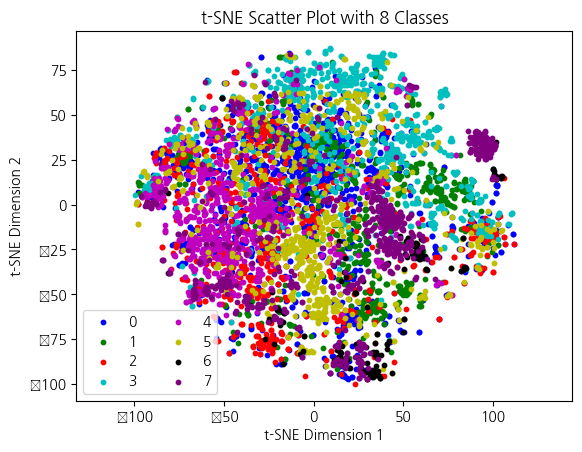

In [87]:
# 클래스 라벨과 색상 설정
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7']
class_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']

# 예를 들어 x와 y는 각각 t-SNE의 결과인 2D 임베딩 좌표입니다.
# 클래스 라벨과 색상을 가진 scatter plot 그리기
for i in range(8):
    plt.scatter(tsne_embeddings[:, 0][rawdata['label_ct'] == i], tsne_embeddings[:, 1][rawdata['label_ct'] == i], c=class_colors[i], label=class_labels[i], s=10)

# x축과 y축 범위 자동 맞춤
plt.axis('equal')    

# legend 추가
plt.legend(loc='lower left', ncol=2)
plt.title('t-SNE Scatter Plot with 8 Classes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.savefig(f"{'result_image/kcBERT_t-SNE_13'}.png", dpi=300)
plt.show()

In [ ]:
# 시각화
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=rawdata['label_ct'], cmap='viridis')
plt.colorbar()

plt.savefig(f"{'result_image/koBERT_t-SNE'}.png", dpi=300)
plt.show()



In [ ]:
# 라벨을 색상으로 표현
label_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # 각 라벨에 대한 색상 설정

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=[label_colors[label] for label in labels], s=10)
plt.colorbar()
plt.show()

# plt.savefig(f"{'kcBERT_t-SNE'}.png", dpi=300)

In [ ]:
# # 텍스트 데이터를 BERT 임베딩으로 변환
# embeddings = []
# labels = []

# for text, label in zip(rawdata['speech'], rawdata['label_ct']):
#     input_ids = tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True)
#     with torch.no_grad():
#         outputs = model(torch.tensor([input_ids]))[0]
#     pooled_output = outputs.mean(dim=1).squeeze().numpy()
#     embeddings.append(pooled_output)
#     labels.append(label)

# # Python 리스트를 NumPy 배열로 변환
# embeddings = np.array(embeddings)

# # t-SNE를 사용하여 임베딩된 데이터를 2D로 축소
# tsne = TSNE(n_components=2, random_state=42)
# tsne_embeddings = tsne.fit_transform(embeddings)

# 라벨을 색상으로 표현
label_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # 8가지 다른 색상 설정

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=[label_colors[label] for label in labels], s=10)
plt.colorbar()
plt.show()

In [ ]:
import seaborn as sns

# 라벨에 대한 색상 매핑
label_colors = sns.color_palette("Set1", n_colors=7)

# 시각화 (색상으로 라벨 표현)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=label_colors, s=10)
plt.show()


# 라벨을 범주로 표현 (예: 0, 1, 2, ...)
markers = ['0', '1', '2', '3', '4', '5', '6', '7]  # 다른 심볼을 사용하여 범주 표현
for i, label_value in enumerate(set(labels)):
    label_indices = [j for j, label in enumerate(labels) if label == label_value]
    plt.scatter(tsne_embeddings[label_indices, 0], tsne_embeddings[label_indices, 1], 
                marker=markers[i], label=f'Label {label_value}', s=10)

plt.legend()
plt.show()


# predict

In [ ]:
label_dict
reverse_label_dict = dict(map(reversed,label_dict.items()))
reverse_label_dict

In [ ]:
# 입력 데이터 준비 (위 예제와 유사한 방법으로)
input_data = [
    "잘 하네",
    "이거는 여기 위에 올려두자",
    "책을 다 읽었구나",
    "신발 벗어",
    "더럽히면 안돼",
    "신발짝을 잘 맞춰 정리했구나 잘 했어",
    "언제 집에 갈까",
    "판다는 대나무를 먹는데"
    ]
input_encodings = tokenizer(input_data, padding=True, truncation=True, return_tensors="pt")

# 모델에 입력 데이터 전달
with torch.no_grad():
    output = loaded_model(**input_encodings)

# 예측 결과 확인
logits = output.logits
predicted_labels = logits.argmax(dim=1)


# 예측 결과 출력
for i, input_text in enumerate(input_data):
    predicted_label = predicted_labels[i].item()
    print(f"Input: {input_text} - Predicted Label: {reverse_label_dict[predicted_label]}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
print(input_encodings)

In [ ]:
# # 실제 정답 y_test과 예측값 y_pred 비교하여 평가
# from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score



In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds, normalize="true")
#     fig, ax = plt.subplots(figsize=(6, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
#     plt.title("Normalized confusion matrix")
#     plt.show()

# y_preds = loaded_model.predicted_labels(X_valid)
# plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
# print(val_text['input_ids'])
# print(loaded_model(val_text['input_ids']))

In [ ]:
type(output)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn import metrics

input_encodings = tokenizer(input_data, padding=True, truncation=True, return_tensors="pt")

# 모델에 입력 데이터 전달
for index,val in enumerate(input_encodings):
    # print(val['input_ids'])
    output = loaded_model(val)

In [ ]:
# 예측 결과 확인
logits = output.logits
predicted_labels = logits.argmax(dim=1)


# # 예측 결과 출력
# for i, input_text in enumerate(input_data):
#     predicted_label = predicted_labels[i].item()
#     print(f"Input: {input_text} - Predicted Label: {reverse_label_dict[predicted_label]}")

# input_encodings = tokenizer(valid_texts, return_tensors="pt")

y_preds = []
y_trues = []
for index,val_text in enumerate(valid_texts):
     val_encoding = tokenizer([val_text], padding=True, truncation=True, return_tensors="pt")

     output = loaded_model(val_encoding)

     print(output)
     logits = output.logits
     prediction = logits.argmax(dim=1)
     prediction = prediction[index].items()
     print(prediction)
     y_pred = torch.argmax(prediction).numpy()
     y_true = val_labels[index]
     # print(y_true)
     y_preds.append(y_pred)
     y_trues.append(y_true)

confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=["0", "1", "2", "3", "4", "5", "6", "7"])
print(confusion_matrix)

In [ ]:
# for index,val_text in enumerate(valid):
#     print(tokenizer.decode(val_text['input_ids'], skip_special_tokens=True))

In [ ]:
# test_loader가 없는뎅
actual_label, predicted_label = predict(loaded_model, valid_loader, device=device)
actual_label = np.array([item.to('cpu') for item in actual_label])
predicted_label = np.array([item.to('cpu') for item in predicted_label])

print("Accuracy :",metrics.accuracy_score(actual_label, predicted_label))
print("f1 score macro :",metrics.f1_score(actual_label, predicted_label, average = 'macro'))
print("f1 scoore micro :",metrics.f1_score(actual_label, predicted_label, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(actual_label, predicted_label))
print("Classification Report: \n", classification_report(actual_label, predicted_label))
print("Confusion Matrix: \n", confusion_matrix(actual_label, predicted_label))

In [ ]:
y_eval = eval[
cm = metrics.confusion_matrix(y_eval, predic_y)